In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import time

import mitsuba as mi
import drjit as dr

print(mi.variants())
os.environ['VARIANT'] = 'llvm_ad_rgb'

sys.path.append('..')

from ris_render.integrators.isir_integrator import ISIRIntegrator
from ris_render.integrators.custom_direct import RISIntegrator

['scalar_rgb', 'scalar_spectral', 'cuda_ad_rgb', 'llvm_ad_rgb']


In [2]:
root_path = Path().cwd().parent

In [3]:
from ris_render.integrators.control_variate import PolyControlVariate

In [10]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


def get_multiindex_2d(degree):
    multiindex = []
    for d in range(degree + 1):
        ar = np.arange(d + 1)
        multiindex.extend(list(zip(ar, d - ar)))
        
    return np.array(multiindex)


class Poly:
    def __init__(self, spatial_size: int, dim: int = 2, degree: int = 1):
        self.spatial_size = spatial_size
        self.dim = dim
        if dim != 2:
            raise NotemplementedError
        self.multiindex = get_multiindex_2d(degree)[1:]
        self.degree = degree
        self.ones = np.ones((spatial_size, len(self.multiindex)))
        
    def feature(self, sample):
        assert sample.shape == (self.spatial_size, self.dim), sample.shape
        feature = jnp.expand_dims(sample, 1).repeat(len(self.multiindex), 1)
        feature = feature ** self.multiindex[None, :]
        return feature
        
    def forward(self, sample):
        feature = self.feature(sample)
        return jnp.einsum('ab,ab->a', self.ones, feature.prod(-1))
    
    def __cal__(self, sample):
        return self.forward(sample)
    
    @property
    def grad(self):
        return grad(lambda x: jnp.einsum('ab,ab->a', self.ones, x.prod(-1)).sum())
    
    @property
    def div(self):
        return lambda y: np.stack([
            grad(lambda x: self.grad(x)[..., 0].sum())(y)[..., 0], 
            grad(lambda x: self.grad(x)[..., 1].sum())(y)[..., 1]
        ], -1)

    
class PolyControlVariate:
    def __init__(self, spatial_size: int, dim: int = 2, degree: int = 1):
        self.spatial_size = spatial_size
        self.dim = dim
        self.degree = degree
        self.poly = Poly(spatial_size, dim, degree)
        self.cov = jnp.zeros((spatial_size, len(self.poly.multiindex), len(self.poly.multiindex)))
        self.mean = jnp.zeros((spatial_size, len(self.poly.multiindex), 3))
        self.n = 0
        self.param = np.zeros((spatial_size, len(self.poly.multiindex), 3))
        
#     def update(self, sample, score, value):
#         value = jnp.array(value)
#         score = jnp.array(score)
#         feature = self.poly.feature(sample)
#         grad = 
#         # feature = self.feature(sample, score)
#         # self.mean = (self.n * self.mean - feature[..., None] * value[:, None, :]) / (self.n + 1)
        
#         self.mean = (self.n * self.mean - score[..., None] * value[:, None, :]) / (self.n + 1)
#         self.cov = ((self.n) * self.cov + np.einsum('ab,ac->abc', score, score)) / (self.n + 1)
#         self.n += 1

    def b(self, sample, score):
        score = jnp.array(score)
        sample = jnp.array(sample)
        feature = self.poly.feature(sample)
        dot = (self.poly.grad(feature) * score[:, None, :]).sum(-1)
        div = self.poly.div(feature).sum(-1)
        res = div + dot
        return res

    def set_mean(self, bs, vals):
        self.mean = ((bs - bs.mean(0)[None, ...])[..., None] * (vals - vals.mean(0)[None, ...])[..., None, :]).mean(0)
        
    def set_cov(self, bs):
        c = (bs - bs.mean(0)[None, ...])
        self.cov = np.einsum('abc,abd->abcd', c, c).mean(0)
        
    def set_param(self):
        inv_cov = np.linalg.pinv(self.cov, rcond=1e-5) # well...
        self.param = np.einsum('abc,abd->acd', inv_cov, self.mean)
    
    def forward(self, sample, score):
        b = self.b(sample, score)
        return np.einsum('abc,ab->ac', self.param, b) * 0.01
    
    def __call__(self, sample, score):
        return self.forward(sample, score)
    
        

cornell-box


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]
/tmp/ipykernel_14152/975793181.py:38: RuntimeWarning: invalid value encountered in power
  plt.imshow(np.array(x) ** (1. / 2.2))


34.9980160970008


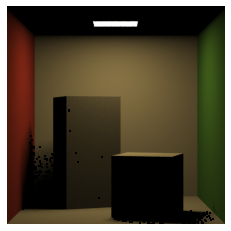

In [11]:
N_PARTICLES = 5
WEIGHT_POPULATION = False
AVG_CHAIN = True
STEPS = 10 #20

DIM = 2
POLY_DEGREE = 2
    
trg_dir = Path('../isir_results')
trg_dir.mkdir(exist_ok=True)
for path in Path(root_path, "scenes").glob('*'):
    if path.stem != 'cornell-box':
        continue
    if path.stem in ('teapot', 'dragon', 'veach-ajar'):
        continue
    print(path.stem)
    try:
        scene = mi.load_file(Path(path, "scene.xml").as_posix())
    except:
        continue
    wavefront_size = np.prod(mi.traverse(scene)['PerspectiveCamera.film.size'])
    
    props = mi.Properties()
    props['emitter_samples'] = STEPS
    props['bsdf_samples'] = 0

    cv = PolyControlVariate(wavefront_size, DIM, POLY_DEGREE)
    integrator = ISIRIntegrator(props, n_particles=N_PARTICLES, weight_population=WEIGHT_POPULATION, avg_chain=AVG_CHAIN, cv=cv)
    
    start = time.perf_counter()
    img_scene = mi.render(scene, integrator=integrator, spp=1)
    
    x = mi.Bitmap(img_scene)
    elapsed = time.perf_counter() - start
    print(elapsed)
    
    
    plt.imshow(np.array(x) ** (1. / 2.2))
    plt.axis("off")
    plt.savefig(Path(trg_dir, f'{path.stem}_isir_{N_PARTICLES}p_{STEPS}s.png'))
    
    
    # props = mi.Properties()
    # props['emitter_samples'] = STEPS
    # props['bsdf_samples'] = 0

    # integrator = ISIRIntegrator(props, n_particles=N_PARTICLES, weight_population=False, avg_chain=True)

    # start = time.perf_counter()
    # img_scene = mi.render(scene, integrator=integrator, spp=1)
    # x = mi.Bitmap(img_scene)
    # elapsed = time.perf_counter() - start
    # print(elapsed)
    
    
    # plt.imshow(np.array(x) ** (1. / 2.2))
    # plt.axis("off")
    # plt.savefig(Path(trg_dir, f'{path.stem}_isir_{N_PARTICLES}p_{STEPS}s_avg.png'))
    
    
    # props = mi.Properties()
    # props['emitter_samples'] = STEPS
    # props['bsdf_samples'] = 0

    # integrator = ISIRIntegrator(props, n_particles=N_PARTICLES, weight_population=True, avg_chain=True)

    # start = time.perf_counter()
    # img_scene = mi.render(scene, integrator=integrator, spp=1)
    # x = mi.Bitmap(img_scene)
    # elapsed = time.perf_counter() - start
    # print(elapsed)
    
    
    # plt.imshow(np.array(x) ** (1. / 2.2))
    # plt.axis("off")
    # plt.savefig(Path(trg_dir, f'{path.stem}_isir_{N_PARTICLES}p_{STEPS}s_avg_rao.png'))
    
    
#     props = mi.Properties()
#     props['emitter_samples'] = STEPS * N_PARTICLES
#     props['bsdf_samples'] = 0

#     integrator = RISIntegrator(props)

#     start = time.perf_counter()
#     img_scene = mi.render(scene, integrator=integrator, spp=1)
#     x = mi.Bitmap(img_scene)
#     elapsed = time.perf_counter() - start
#     print(elapsed)

#     plt.imshow(np.array(x) ** (1. / 2.2))
#     plt.axis("off")
#     plt.savefig(Path(trg_dir, f'{path.stem}_ris_{STEPS * N_PARTICLES}s.png'))
    
#     props = mi.Properties()
#     props['emitter_samples'] = STEPS
#     props['bsdf_samples'] = 0

#     integrator = RISIntegrator(props)

#     start = time.perf_counter()
#     img_scene = mi.render(scene, integrator=integrator, spp=1)
#     x = mi.Bitmap(img_scene)
#     elapsed = time.perf_counter() - start
#     print(elapsed)

#     plt.imshow(np.array(x) ** (1. / 2.2))
#     plt.axis("off")
#     plt.savefig(Path(trg_dir, f'{path.stem}_ris_{STEPS}s.png'))
    
#     props = mi.Properties()
#     props['emitter_samples'] = STEPS
#     props['bsdf_samples'] = 0

#     integrator = RISIntegrator(props)

#     start = time.perf_counter()
#     img_scene = mi.render(scene, integrator=integrator, spp=STEPS)
#     x = mi.Bitmap(img_scene)
#     elapsed = time.perf_counter() - start
#     print(elapsed)

#     plt.imshow(np.array(x) ** (1. / 2.2))
#     plt.axis("off")
#     plt.savefig(Path(trg_dir, f'{path.stem}_ris_{STEPS}s_{STEPS}spp.png'))
#     plt.close()

    break

In [12]:
cv.param.min()

-13.7269745